# Машинное обучение, ФКН ВШЭ

# Практическое задание 13. Рекомендательные системы

## Общая информация
**Дата выдачи: 20.05.2022**

**Мягкий дедлайн: 03.06.2022 23:59 MSK**

**Жёсткий дедлайн: 08.06.2022 23:59 MSK**

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — **11** баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-13-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

## О задании

В этой работе мы будем решать задачу рекомендаций музыки. Для этого мы реализуем метод коллаборативной фильтрации и модель со скрытыми переменными, сравним их между собой и попытаемся сделать выводы. Во всех заданиях разрешается переписывать код по своему усмотрению, предложенные шаблоны несут лишь рекомендательный характер. За дополнительные эксперименты с методами и их анализ можно получить бонусные баллы.

In [1]:
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from typing import Callable, List

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as scs

In [2]:
ratings = pd.read_csv('music_dataset.csv')
ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [3]:
tracks_info = pd.read_csv('tracks_info.csv')
tracks_info.head()

,id,name,artists
0,0,What There Is,['a-ha']
1,1,I'll Play The Blues For You,['Albert King']
2,2,Breaking Up Somebody's Home,['Albert King']
3,3,Imma Be,['Black Eyed Peas']
4,4,Boom Boom Pow,['Black Eyed Peas']


In [4]:
"['Lamb Of God']" in list(tracks_info.artists.unique())

True

In [5]:
tracks_info[tracks_info.artists == "['Lamb Of God']"]

,id,name,artists
2406,2406,In Your Words,['Lamb Of God']
2407,2407,Broken Hands,['Lamb Of God']
6547,6547,Walk with Me In Hell,['Lamb Of God']
6548,6548,Redneck,['Lamb Of God']
6549,6549,Laid to Rest,['Lamb Of God']


Для оценки качества рекомендаций мы будем использовать метрику $MAP@k$.

$$
MAP@k = \frac{1}{N} \sum_{u = 1}^N AP_u@k
$$
$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)$$


*   $N$ - количество пользователей.
*   $n_u$ - число релевантных треков пользователя $u$ на тестовом промежутке.
*   $r_u(i)$ - бинарная величина: относится ли трек на позиции $i$ к релевантным.

**Задание 1 (1 балл).** Реализуйте метрику $MAP@k$.

In [6]:
pp = np.array([1, 0, -1, 4, 9, 10])
rr = np.array([[1, 2, 3, 4]] * len(pp))
rr, pp

(array([[1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4],
        [1, 2, 3, 4]]), array([ 1,  0, -1,  4,  9, 10]))

In [7]:
np.isin(pp, rr).astype(int)

array([1, 0, 0, 1, 0, 0])

In [8]:
def ru_is(user_ind, relevant: list, predicted: list) -> np.array:
    rev_dupl = np.array([relevant[user_ind]] * len(predicted[user_ind])) 
    pru = np.array(predicted[user_ind])
    
    # len = len(predicted[user_ind])
    contains = np.isin(pru, rev_dupl).astype(int)
    return contains


def precisonk(relevant, predicted, k=20) -> list:
    pr_list = []
    for user_ind in range(len(relevant)):
        # чтобы понять, что здесь происходит -- см. ячейки сверху
        contains = ru_is(user_ind, relevant, predicted)[:k]
        pr_list += [np.sum(contains) / k]
        
    # len = users count
    return pr_list


def apk(relevant, predicted, k=20) -> list:
    pr_precompute = []
    for i in range(1, k + 1):
        pr_precompute += [precisonk(relevant, predicted, i)]

    # shape = (n_users, k)
    pr_precompute = np.asarray(pr_precompute).T
    
    apks = []
    for user_ind in range(len(relevant)):
        n_tracks_u = len(relevant[user_ind])
        contains = ru_is(user_ind, relevant, predicted)
        user_prs = pr_precompute[user_ind]
        apk = np.dot(contains[:k], user_prs) / min(k, n_tracks_u)
        apks += [apk]
    return apks
        

def mapk(relevant: List[List[int]], predicted: List[List[int]], k=20):
    apks = apk(relevant, predicted, k)
    return np.mean(apks)

In [9]:
relevant = [
    [1, 7, 6, 2, 8],
    [1, 5, 4, 8],
    [8, 2, 5]
]

pred = [
    [8, 1, 5, 0, 7, 2, 9, 4],
    [0, 1, 8, 5, 3, 4, 7, 9],
    [9, 2, 0, 6, 8, 5, 3, 7]
]

assert round(mapk(relevant, pred, k=5), 4) == 0.4331

Разделим данные на тренировочные и тестовые так, чтобы в теcтовый датасет попали 50 последних треков каждого пользователя.

In [10]:
def train_test_split(ratings):
    train_ratings, test_ratings = [], []
    num_test_samples = 50

    # getting train samples
    for userId, user_data in tqdm(ratings.groupby('userId')):
        train_ratings += [user_data[:-num_test_samples]]

    train_ratings = pd.concat(train_ratings).reset_index(drop=True)
    all_train_items = train_ratings['trackId'].unique()

    # getting train samples
    # we drop all tracks that are not presented it the training samples,
    # because we won't be able to learn representations for them
    for userId, user_data in tqdm(ratings.groupby('userId')):
        test_items = user_data[-num_test_samples:]
        test_items = test_items[np.isin(test_items['trackId'], all_train_items)]
        test_ratings += [test_items]

    test_ratings = pd.concat(test_ratings).reset_index(drop=True)

    return train_ratings, test_ratings

In [11]:
train_ratings, test_ratings = train_test_split(ratings)

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

Почистим табличку с информацией о треках и закодируем id треков так, чтобы они соответствовали их порядковому номеру.

In [12]:
redundant_rows = np.where(~np.isin(tracks_info['id'], train_ratings['trackId'].unique()))[0]
tracks_info.drop(redundant_rows, inplace=True)
tracks_info = tracks_info.reset_index(drop=True)

In [13]:
def ids_encoder(ratings):
    users = sorted(ratings['userId'].unique())
    items = sorted(ratings['trackId'].unique())

    # create users and items encoders
    uencoder = LabelEncoder()
    iencoder = LabelEncoder()

    # fit users and items ids to the corresponding encoder
    uencoder.fit(users)
    iencoder.fit(items)

    return uencoder, iencoder

In [14]:
uencoder, iencoder = ids_encoder(train_ratings)
train_ratings['trackId'] = iencoder.transform(train_ratings['trackId'].tolist())
test_ratings['trackId'] = iencoder.transform(test_ratings['trackId'].tolist())
tracks_info['id'] = iencoder.transform(tracks_info['id'].tolist())

In [15]:
train_ratings.head()

,userId,trackId
0,0,14
1,0,95
2,0,219
3,0,220
4,0,404


In [16]:
test_ratings.head()

,userId,trackId
0,0,57582
1,0,57802
2,0,57957
3,0,58174
4,0,59168


Соберем все релевантные треки для каждого пользователя в список.

In [17]:
TEST_RELEVANT = []
TEST_USERS = []
for user_id, user_data in test_ratings.groupby('userId'):
    TEST_RELEVANT += [user_data['trackId'].tolist()]
    TEST_USERS.append(user_id)

**Задание 2 (0.5 балла).** Реализуйте метод `get_test_recommendations` в классе `BaseModel`. Он принимает на вход параметр `k` и возвращает массив из `k` наиболее подходящих треков для каждого пользователя. Не забывайте удалять уже прослушанные треки из рекомендуемых.

In [18]:
class BaseModel:
    def __init__(self, ratings: pd.DataFrame):
        self.ratings = ratings
        self.users = np.unique(self.ratings['userId'])
        self.items = np.unique(self.ratings['trackId'])
        self.n_users = len(self.users)
        self.n_items = len(self.items)

        # бинарная матрица рейтингов - понравилось/не понравилось
        self.R = np.zeros((self.n_users, self.n_items), dtype='int')
        self.R[self.ratings['userId'], self.ratings['trackId']] = 1
        
    def recommend(self, uid: int) -> list:
        """
        param uid: int - user's id
        return: [n_items] - vector of recommended items sorted by their scores in descending order
        """
        raise NotImplementedError

    def remove_train_items(self, preds: List[List[int]], k: int):
        """
        param preds: [n_users, n_items] - recommended items for each user
        param k: int
        return: np.array [n_users, k] - recommended items without training examples
        """
        new_preds = np.zeros((len(preds), k), dtype=int)
        for user_id, user_data in self.ratings.groupby('userId'):
            user_preds = preds[user_id]
            new_preds[user_id] = user_preds[~np.in1d(user_preds, user_data['trackId'])][:k]
        return new_preds

    def get_test_recommendations(self, k: int, _test_users=None):
        if _test_users is None:
            print('_test_users variable is None! Use global name TEST_USERS')
            _test_users = TEST_USERS
            
        test_preds = []
        for user in self.users:
            test_preds += [self.recommend(user)]
        return self.remove_train_items(test_preds, k)[_test_users]

## Часть 1. Коллаборативная фильтрация (User2User)

Идея: чтобы выбрать треки, которые понравятся пользователю, можно набрать несколько похожих на него пользователей (соседей) и посмотреть, какие треки они слушают. После этого остается агрегировать треки этих пользователей и выбрать самые популярные. Соответственно, задача состоит из двух частей: выбора функции похожести двух пользователей и способа агрегации.

В качестве функции похожести мы будем использовать две метрики:

1. Корреляция Пирсона $$s(u, v) = \frac{\sum_{i \in I_u \cap I_v} r_{ui}r_{vi}}{\sqrt{\sum_{i \in I_u} r_{ui} ^2}\sqrt{\sum_{i \in I_v} r_{vi}^2}} $$

2. Мера Жаккара

$$ s(u, v) = \frac{|I_u \cap I_v|}{|I_u \cup I_v|} $$


Корреляция Пирсона немного видоизменена, чтобы подходить под нашу задачу.


Во всех формулах 
* $I_u$ - множество треков, прослушанных пользователем $u$.
* $r_{ui}$ - прослушал ли пользователь $u$ трек $i$ (0 или 1).

Множество соседей определим как $$N(u) = \{ v \in U \setminus \{u\} \mid s(u, v) > \alpha\},$$ где $\alpha \, - $ гиперпараметр.



Для агрегации мы будем пользоваться следующей формулой.
$$
\hat{r}_{ui} = \frac{\sum_{v \in N(u)} s(u, v) r_{vi}}{\sum_{v \in N(u)} |s(u, v)|}
$$

**Задание 3.1 (1 балл).** Реализуйте функцию подсчета корреляции Пирсона.

**Задание 3.2 (0.5 балла).** Реализуйте функцию подсчета меры Жаккара.

Функции принимают матрицу оценок и вектор оценок пользователя $u$ и возвращают вектор со значениями похожести пользователя $u$ на всех пользователей. Старайтесь писать оптимизированный код, за неэффективную реализацию оценка может быть снижена.

In [19]:
'''
    ratings = binary matrix of shape (nu, ni)
    user_vector = binary (?) vector on shape (ni,)
'''


def pearson(ratings: np.array, user_vector: np.array) -> np.array:
    # матрица матчинга прослушиваний
    matching_users = ratings * user_vector
    matching_sums = np.sum(matching_users, axis=1)

    # норма данного пользователя
    norm_given = np.sqrt(np.sum(user_vector))
    # нормы остальных пользователей
    norms_other = np.sum(ratings, axis=1)

    norms = norm_given * norms_other
    return matching_sums / norms_other


def jaccard(ratings: np.array, user_vector: np.array) -> np.array:
    intersect = np.sum(ratings * user_vector, axis=1)
    bitwise = ratings | user_vector
    union = np.sum(bitwise, axis=1)
    return intersect / union

In [20]:
aa = np.array([[0, 0, 1, 0],
               [1, 1, 0, 0],
               [0, 1, 1, 0]])
uu = np.array([0, 1, 0, 1])

pearson(aa, uu)

array([0. , 0.5, 0.5])

In [21]:
jaccard(aa, uu)

array([0.        , 0.33333333, 0.33333333])

**Задание 4 (1 балл).** Реализуйте методы `similarity` и `recommend` класса `User2User`. `recommend` возвращает индексы треков, отсортированные в порядке убывания предсказанных оценок.


In [22]:
class User2User(BaseModel):
    def __init__(self, ratings, similarity_func, alpha=0.02):
        '''
            alpha -- corr. treshold
        '''
        super().__init__(ratings)

        assert similarity_func in [pearson, jaccard]

        self.similarity_func = similarity_func
        self.alpha = alpha

    def similarity(self, user_vector: np.array, uid=None):
        """
            user_vector: [n_items]
        """
        return self.similarity_func(self.R, user_vector)
    
    def get_Nu(self, uid, similarities, alpha):
        sim_inds = np.argwhere(similarities > alpha)[:, 0]
        Nu_inds = sim_inds[sim_inds != uid]
        return Nu_inds

    def recommend(self, uid: int):    
        user_vector = self.R[uid]
        similarities = self.similarity(user_vector)

        alpha = self.alpha
        Nu_inds = self.get_Nu(uid, similarities, alpha)
        
        while (len(Nu_inds) == 0):
            alpha *= 0.7
            Nu_inds = self.get_Nu(uid, similarities, alpha)
            
        new_sims = similarities[Nu_inds]
        predicts = np.sum(self.R[Nu_inds] * new_sims[:, None], axis=0) / np.sum(np.abs(new_sims))
        # inds = np.argsort(-predicts) -- another result
        inds = np.argsort(predicts)[::-1]
        return inds

In [23]:
# uid = 2
# R = np.array([
#     [0, 0, 1, 0, 0, 1],
#     [1, 1, 0, 1, 0, 1],
#     [0, 1, 1, 1, 0, 0],
#     [1, 0, 0, 0, 1, 1],
#     [0, 1, 0, 1, 0, 0],
# ])
# user_vector = R[uid]

# similarities = pearson(R, user_vector)
# sim_inds = np.argwhere(similarities > 0.02)[:, 0]
# Nu_inds = sim_inds[sim_inds != uid]
        
# new_sims = similarities[Nu_inds]
# print(similarities, sim_inds, new_sims, Nu_inds)
# print()

# predicts = np.sum(R[Nu_inds] * new_sims[:, None], axis=0) / np.sum(np.abs(new_sims))
# print(predicts)
# predicts[np.argsort(predicts)[::-1]]

**Задание 5 (1 балл).** Постройте графики зависимости значений $MAP@k$ от разных $k$ для обоих функций похожести, сравните их между собой, а также с предсказаниями случайного алгоритма и сделайте выводы.

In [24]:
Ks = np.arange(2, 70, 2)

class RandomRec(BaseModel):
    def __init__(self, ratings):
        super().__init__(ratings)

    def recommend(self, uid: int):
        return np.random.rand(self.n_items)

model = User2User(train_ratings, pearson)
pearson_preds = model.get_test_recommendations(70)

model.similarity_func = jaccard
jaccard_preds = model.get_test_recommendations(70)

model = RandomRec(train_ratings)
random_preds = model.get_test_recommendations(70)

_test_users variable is None! Use global name TEST_USERS
_test_users variable is None! Use global name TEST_USERS
_test_users variable is None! Use global name TEST_USERS


In [25]:
pearson_mapk = [mapk(TEST_RELEVANT, pearson_preds, k) for k in Ks]
jaccard_mapk = [mapk(TEST_RELEVANT, jaccard_preds, k) for k in Ks]
rand_mapk =    [mapk(TEST_RELEVANT, random_preds, k) for k in Ks]

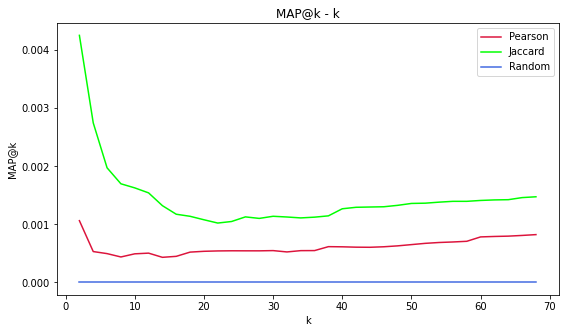

In [26]:
labels = ['Pearson', 'Jaccard', 'Random']
colors = ['crimson', 'lime', 'royalblue']

plt.figure(figsize=(9, 5))

for i, mapks in enumerate([pearson_mapk, jaccard_mapk, rand_mapk]):
    plt.plot(Ks, mapks, label=labels[i], color=colors[i])

plt.title('MAP@k - k')
plt.xlabel('k')
plt.ylabel('MAP@k')
plt.legend()
plt.show()

Что ж, насчет случайных предсказаний -- все понятно, этого и следовало ожидать. Функция Жаккарта лучше, чем Пирсона, что, в целом, неудивительно, так как первая лучше подходит для задачи с бинарным рейтингом в силу своего устройства. Смущает то, что значениях обоих метрик экстремально малые (думаю, такова специфика задачи и данных), и их наибольшие значения достигаются при малых k. Примечально, что после k = 35 значение MAP@K начинает монотонно неубывать.

**Бонус (1.5 балла).** Как вы могли заметить, матрица оценок получается очень разреженной, но мы работаем с ней как с обычной, это не дело. Перепишите код так, чтобы все методы могли работать с разреженными матрицами и сравните скорость работы такого подхода с оригинальным.

In [27]:
# your code here: ‿︵‿︵ヽ(°□° )ノ︵‿︵‿

Мы можем посмотреть глазами, насколько хорошо модель рекомендует треки. Для этого сравним уже прослушанные треки с рекомендованными и релевантными для случайного пользователя. Хорошо ли у вас получилось?

In [28]:
model = model = User2User(train_ratings, jaccard)
user_id = np.random.randint(0, model.n_users)

In [29]:
listened_tracks = train_ratings[train_ratings.userId == user_id].trackId[:15]

print('Already listened tracks:')
tracks_info.loc[listened_tracks][['name', 'artists']]

Already listened tracks:


,name,artists
1012,Wishmaster,['Nightwish']
1421,Du bist so Porno,"['Alex C.', 'YASS']"
1610,The Reason,['Hoobastank']
1714,Losing You,['Dead by April']
1726,My Turn,['Hoobastank']
1728,Moving Forward,['Hoobastank']
1729,Don't Tell Me,['Hoobastank']
1730,If Only,['Hoobastank']
1731,More Than A Memory,['Hoobastank']
1732,Inside Of You,['Hoobastank']


In [30]:
preds = model.get_test_recommendations(15)

print('Predicted tracks:')
tracks_info.loc[preds[user_id]][['name', 'artists']]

_test_users variable is None! Use global name TEST_USERS
Predicted tracks:


,name,artists
8481,Wicked Game,['HIM']
1624,Knockin' On Heaven's Door,"[""Guns N' Roses""]"
474,Tom's Diner,"['DNA', 'Suzanne Vega', 'Nick Batt', 'Neal Sla..."
12202,The House Of The Rising Sun,['The Animals']
11060,The Sign,['Ace of Base']
19496,Angel,['Theory Of A Deadman']
5872,Я свободен,['Кипелов']
6840,Holy Mountains,['System of A Down']
1666,Faint,['Linkin Park']
6841,Lonely Day,['System of A Down']


In [31]:
test_tracks = test_ratings[test_ratings.userId == user_id].trackId[:15]

print('Test-time tracks:')
tracks_info.loc[test_tracks][['name', 'artists']]

Test-time tracks:


,name,artists
53447,Arcadia,['Smash Into Pieces']
54265,Gravity,['Metrik']
55871,Nightmare,['The Veer Union']
56258,Infinite,"['Silverstein', 'Aaron Gillespie']"
56498,Mad World,['Smash Into Pieces']
58149,Everything They S4Y,['Smash Into Pieces']
59171,Entertain You,['Within Temptation']
60341,Like a Parasite,['Annisokay']
61127,Bonfire of the Millennials,['Annisokay']
61808,Somebody Told Me,['Motionless In White']


Я запускал много раз, и на самом деле результаты не очень. Однако с метальчиком работает ок -- специфика жанра и его слушателей. В этом случае делаем в принципе адекватные предстазания, но может быть такое, что на тесте у человека там Клава Кока и прочая нечисть.

### Часть 2. Модель со скрытыми переменными

В этой части мы пощупаем метод рекомендаций со скрытыми переменными.
Идея: будем предсказывать оценки по формуле
$$
\hat{r}_{ui} = \langle p_u, q_i \rangle,
$$
$p_u \in \mathbb{R}^d$ и $q_i \in \mathbb{R}^d$ - латентные векторы пользователя $u$ и объекта $i$ соответственно. 

Оптимизировать мы будем MSE между истинной оценкой пользователя и предсказанной с регуляризацией
$$
L = \sum_{(u, i) \in R} (\hat{r}_{ui} - r_{ui})^2 + \lambda \left(\sum_{u \in U} \|p_u\|^2 + \sum_{i \in I} \|q_i\|^2\right)
$$

**Задание 6 (1.5 балла).** На лекции рассматривались два подхода к оптимизации параметров. Можно это делать обычным стохастическим градиентным спуском, а можно по очереди обновлять матрицы $P, Q$, и тогда получится метод Alternating Least Squares (ALS). Выведите формулы обновления параметров для обоих методов.

В нашей задаче рейтинг -- бинарный, значит, можно считать, что он существует всегда.

$$
\nabla_{p_u} L = \sum\limits_i 2(r_{ui} - \langle q_i, p_u \rangle)q_i + 2\lambda p_u \propto \sum\limits_{i}r_{ui}q_i - (\sum\limits_{i}q_i q_i^T)p_u + \lambda p_u 
$$

**LFM:**

Ответ

Чтобы получить шаги для SGD, нужно зафиксировать пару (u, i)

$$p_{uk} := p_{uk} + 2\eta \cdot q_{ik}(r_{ui} - \langle p_u, q_i \rangle) + 2\eta \lambda p_u$$

$$q_{ik} := q_{ik} + 2\eta \cdot p_{uk}(r_{ui} - \langle p_u, q_i \rangle) + 2\eta \lambda q_i$$

\
**ALS:**

Ответ

$$
\nabla_{p_u} L = 0 \Longrightarrow \\
p_u = \left(\sum\limits_{i}q_i q_i^T + \lambda I\right)^{-1} \sum\limits_{i}r_{ui}q_i\ \ \forall\ u
$$

$$
q_i = \left(\sum\limits_{u}p_u p_u^T + \lambda I\right)^{-1} \sum\limits_{u}r_{ui}p_u\ \ \forall\ i
$$

**Задание 7 (2 балла).** Реализуйте методы оптимизации параметров для обоих алгоритмов.

In [106]:
from scipy.sparse.csr import csr_matrix

def compute_inved(M, lamb, split=None):
    dim = M.shape[1]
    if split is None:
        MM = (M.reshape(-1, dim, 1) * M.reshape(-1, 1, dim)).sum(axis=0)
        MM_inved = np.linalg.inv(MM + 2 * lamb * np.eye(dim)) # shape = (dim, dim)
    elif split is not None:
        if split == 'auto':
            split = int(M.shape[0] / dim * 1.5)
        M_splitted = np.array_split(M, split)
        MM = 0
        for s in range(split):
            MM += (M_splitted[s].reshape(-1, dim, 1) * M_splitted[s].reshape(-1, 1, dim)).sum(axis=0)
        del M_splitted
        MM_inved = np.linalg.inv(MM + lamb * np.eye(dim)) # shape = (dim, dim)
    del MM
    return MM_inved


class HiddenVars(BaseModel):
    def __init__(self, ratings, dim=128, mode='sgd', lr=0.2, lamb=0.005):
        super().__init__(ratings)
        self.dim = dim
        
        assert mode in ['sgd', 'als']
        self.mode = mode
        
        self.R = csr_matrix(self.R)
        one = 1 / (2 * self.n_users * dim)
        self.P = np.random.uniform(-one, one, size=(self.n_users, dim))
        two = 1 / (2 * self.n_items * dim)
        self.Q = np.random.uniform(-two, two, size=(self.n_items, dim))

        self.lr = 2 * lr
        self.lamb = lamb

    def loss(self, ord='fro'):
        '''
            2 <<<= fro, but fro is faster
        '''
        return np.linalg.norm(self.R - self.P @ self.Q.T, ord=ord)

    def fit(self, num_iters=5, split='auto', return_losses=False, loss_ord='fro'):
        losses = []
        for epoch in tqdm(range(num_iters), 'epoch'):
            if self.mode == 'sgd':
                u = np.random.randint(low=0, high=self.n_users, size=1)
                i = np.random.randint(low=0, high=self.n_items, size=1)

                pu = self.P[u].reshape(-1)
                qi = self.Q[i].reshape(-1)

                diff = self.R.getcol(i).A[u, 0] - np.dot(pu, qi)
                self.P[u] -= self.lr * qi * diff + self.lr * self.lamb * pu
                self.Q[i] -= self.lr * pu * diff + self.lr * self.lamb * qi

            elif self.mode == 'als':
                QQ_inved = compute_inved(self.Q, self.lamb, split=split)
                for u in range(self.n_users):
                    ru = self.R.getrow(u) # shape = (1, n_items)
                    self.P[u] = QQ_inved @ (ru @ self.Q).reshape((-1,))
                del QQ_inved, ru
                    
                PP_inved = compute_inved(self.P, self.lamb, split=3)
                for i in range(self.n_items):
                    ri = self.R.getcol(i) # shape = (n_users, 1)
                    self.Q[i] = PP_inved @ (ri.T @ self.P).reshape((-1,))
                del PP_inved, ri
            
            if return_losses:
                losses += [self.loss(ord=loss_ord)]
        return losses


    def recommend(self, uid):
        pred_rating = self.P[uid] @ self.Q.T
        return np.argsort(pred_rating)[::-1]

**Задание 8 (1 балл).** Для обоих алгоритмов подберите оптимальные значения размерности скрытого пространства $d$ и размера предсказания $k$. Как изменяется качество предсказаний с числом итераций обучения? Постройте соответствующие графики, сравните со случайным подхом и User2User, сделайте выводы. Какой алгоритм вам кажется более подходящим для данной задачи и почему?

P.S. Хотя бы один из методов обучения должен приводить к лучшим результатам в сравнении с User2User подходом.

P.P.S. Методу LFM свойственно переобучаться, поэтому при подборе параметров полезно смотреть на значения ошибки и оптимизируемой метрики на тренировочном датасете. Вы также можете менять начальную инициализацию и прочие параметры, за исключением архитектуры, на ваш вкус.

Подбор dim, k для ALS.

In [108]:
dims = [64, 128, 256, 512]
Ks = [2, 5, 15, 30]
pairs_test_als = {}

for dim in tqdm(dims, 'dims'):
        model = HiddenVars(train_ratings, dim=dim, mode='als')
        model.fit(split='auto')
        for k in Ks:
            test_preds = model.get_test_recommendations(k, TEST_USERS)
            pairs_test_als[(dim, k)] = mapk(TEST_RELEVANT, test_preds, k)

dims:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

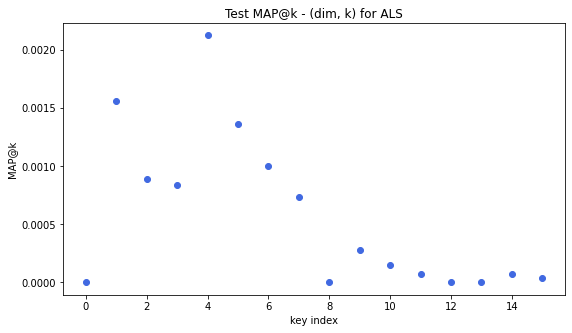

In [109]:
plt.figure(figsize=(9, 5))

for i, key in enumerate(pairs_test_als.keys()):
    plt.scatter(i, pairs_test_als[key], color='royalblue')

plt.title('Test MAP@k - (dim, k) for ALS')
plt.xlabel('key index')
plt.ylabel('MAP@k')
plt.show()

In [110]:
argmax_key_als = max(pairs_test_als, key=pairs_test_als.get)
pairs_test_als[argmax_key_als], argmax_key_als

(0.002127659574468085, (128, 2))

Получается, что для ALS низкоранговая размерность и k -- минимальны (в основном). Однако сильно решает инициализация -- при одних и тех же гиперпараметрах результаты сильно разнятся. Собственно, из-за этого я и поменял начальные инициализации P и Q ($\sim U[-\frac{1}{2m}; \frac{1}{2m}]$), и в целом результат стал более стабилен -- не такая большая дисперсия. Надо фиксировать сид, но тогда по сути сид является гиперпараметром, что плохо.

Попробуем поменять другие параметры.

In [111]:
model_als = HiddenVars(train_ratings, dim=argmax_key_als[0], mode='als', lamb=0.05)
model_als.fit(split='auto', num_iters=8)
test_preds = model_als.get_test_recommendations(argmax_key_als[1], TEST_USERS)
mapk(TEST_RELEVANT, test_preds, k=argmax_key_als[1])

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

0.0010638297872340426

Мой лучший результат -- 0.0010638297872340426, 8 эпох и $\lambda = 0.05$.

Теперь LFM-SGD.

In [117]:
losses_train = {}
pairs_test_lfm = {}

for dim in tqdm(dims, 'dims'):
    model = HiddenVars(train_ratings, dim=dim, mode='sgd', lr=0.3, lamb=0.1)
    losses_train[dim] = model.fit(split='auto', num_iters=70, return_losses=True, loss_ord='fro')
    for k in Ks:
        test_preds = model.get_test_recommendations(k, TEST_USERS)
        pairs_test_lfm[(dim, k)] = mapk(TEST_RELEVANT, test_preds, k)

dims:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/70 [00:00<?, ?it/s]

epoch:   0%|          | 0/70 [00:00<?, ?it/s]

epoch:   0%|          | 0/70 [00:00<?, ?it/s]

epoch:   0%|          | 0/70 [00:00<?, ?it/s]

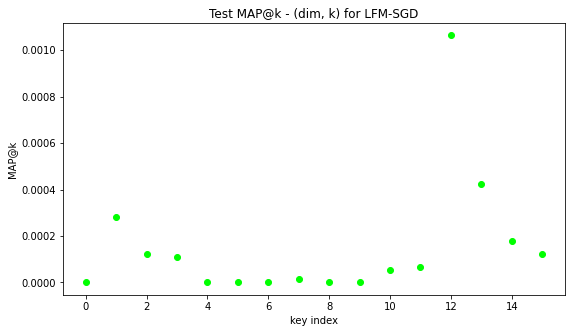

In [118]:
plt.figure(figsize=(9, 5))

for i, key in enumerate(pairs_test_lfm.keys()):
    plt.scatter(i, pairs_test_lfm[key], color='lime')

plt.title('Test MAP@k - (dim, k) for LFM-SGD')
plt.xlabel('key index')
plt.ylabel('MAP@k')
plt.show()

In [119]:
argmax_key_lfm = max(pairs_test_lfm, key=pairs_test_lfm.get)
pairs_test_lfm[argmax_key_lfm], argmax_key_lfm

(0.0010638297872340426, (512, 2))

Лучший результат -- (0.0010638297872340426, (512, 2)) при lr=0.3, $\lambda=0.1$ и 70 итераций. Результат точно такой же, как и у ALS, что очень странно.

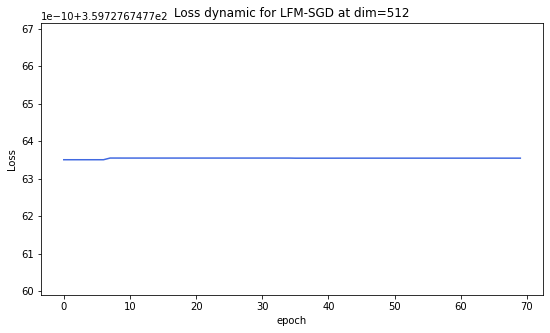

In [121]:
plt.figure(figsize=(9, 5))
plt.plot(losses_train[argmax_key_lfm[0]], color='royalblue')
plt.title('Loss dynamic for LFM-SGD at dim={}'.format(dim))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.show()

Я, честно, не знаю, как это объяснить. Бага вроде нет, но лосс вообще не падает. Возможно, все дело в фробениусовой норме и в той особенности, что за итерацию мы меняем лишь одну пару (u, i). В этом случае это выглядит разумно.

Выведем графики метрики для различного числа итераций.

In [125]:
iters_als = [2, 3, 4, 5, 6]
mapk_als = []

for num_iters in tqdm(iters_als, 'dims'):
    model = HiddenVars(train_ratings, dim=argmax_key_als[0], mode='als')
    model.fit(split='auto', num_iters=num_iters)
    test_preds = model.get_test_recommendations(argmax_key_als[1], TEST_USERS)
    mapk_als += [mapk(TEST_RELEVANT, test_preds, argmax_key_als[1])]

dims:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

epoch:   0%|          | 0/3 [00:00<?, ?it/s]

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch:   0%|          | 0/6 [00:00<?, ?it/s]

In [126]:
iters_lfm = [50, 60, 70, 80, 90, 100]
mapk_lfm = []

for num_iters in tqdm(iters_lfm, 'dims'):
    model = HiddenVars(train_ratings, dim=argmax_key_lfm[0], mode='sgd', lr=0.3, lamb=0.1)
    model.fit(split='auto', num_iters=num_iters)
    test_preds = model.get_test_recommendations(argmax_key_lfm[1], TEST_USERS)
    mapk_lfm += [mapk(TEST_RELEVANT, test_preds, argmax_key_lfm[1])]

dims:   0%|          | 0/6 [00:00<?, ?it/s]

epoch:   0%|          | 0/50 [00:00<?, ?it/s]

epoch:   0%|          | 0/60 [00:00<?, ?it/s]

epoch:   0%|          | 0/70 [00:00<?, ?it/s]

epoch:   0%|          | 0/80 [00:00<?, ?it/s]

epoch:   0%|          | 0/90 [00:00<?, ?it/s]

epoch:   0%|          | 0/100 [00:00<?, ?it/s]

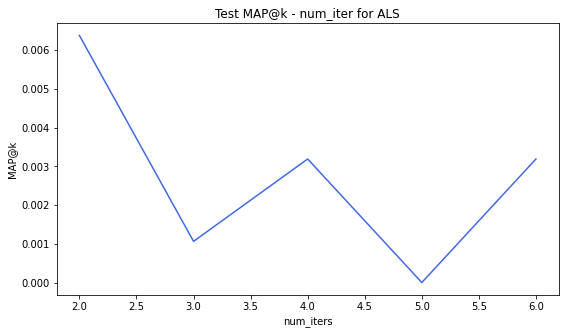

In [130]:
plt.figure(figsize=(9, 5))
plt.plot(iters_als, mapk_als, color='royalblue')
plt.title('Test MAP@k - num_iter for ALS')
plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.show()

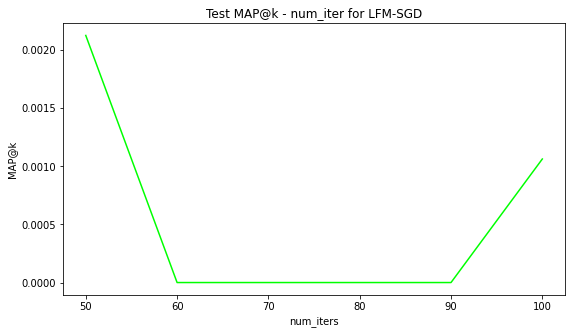

In [131]:
plt.figure(figsize=(9, 5))
plt.plot(iters_lfm, mapk_lfm, color='lime')
plt.title('Test MAP@k - num_iter for LFM-SGD')
plt.xlabel('num_iters')
plt.ylabel('MAP@k')
plt.show()

К сожалению, тут я уже не успеваю все обучить и вывести графики. Предсказать, какие будут результаты -- не могу.

Если в целом сравнивать с User2User, то следует сказать, что модели не всегда работают лучше, однако если поподбирать гиперпараметры, то можно улучшить качество в 2-2.25 раза, что, в принципе, ок. Беда в том, что модели достаточно долго обучаются. Кстати, проверяющему на посмеяться: вот такую багу я словил, из-за которой потерял три часа времени (обе модели обучались только две эпохи):

`for epoch in range(num_iters), 'epoch':`

Вдобавок, основная проблема моделей -- инициализация. Хорошая идея -- ограничивать интервал допустимых значений (выше я писал о том, что это помогает).

Со случайными предсказаниями как-то нет смысла сравнивать -- конечно же лучше (хотя если переобучиться на ALS, то можно получить MAP@k = 0).

Насчет того, какая модель лучше подходит для задачи: ALS или LFM-SGD. Учитывая то, что я получил одинаковое качество на двух моделях, то я бы выбрал LFM: она быстрее, и с ней проще. ALS обучается долго, в неразреженной реализации придется столкнуться с вылетом ОЗУ. В LFM больше гиперпараметров, но скорее всего это делает ее более гибкой и не такой топорной. Иными словами, учитывая одинаковое полученное качество (еще раз подчеркиваю), я бы выбрал LFM в силу ее простоты в реализации.

Если у вас получилось достаточно хорошее качество, то при оптимизации параметров марицы $Q$ похожим трекам стали соответствовать похожие векторы. Поэтому мы можем для любого трека найти наиболее близкие к нему в латентном пространстве и проверить степерь обученности модели вручную.

In [132]:
model = HiddenVars(train_ratings, dim=argmax_key_als[0], mode='als', lamb=0.05)
model.fit(split='auto', num_iters=8)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

[]

In [146]:
example_trackId = tracks_info[tracks_info.name == 'Walk with Me In Hell'].iloc[0].id

preds = model.Q @ model.Q[example_trackId]
preds = preds / np.sqrt((model.Q ** 2).sum(axis=1) + 1e-8)

track_idxs = preds.argsort()[::-1][:20]

In [147]:
similar_tracks = tracks_info.loc[track_idxs][['name', 'artists']]
similar_tracks['similarity'] = preds[track_idxs] / np.linalg.norm(model.Q[example_trackId])
similar_tracks

,name,artists,similarity
10385,Through The Shadow,['Insomnium'],0.999997
12194,Behaving Badly,['Animals as Leaders'],0.999997
10119,Country Song,['Seether'],0.999997
1536,Feel Good Drag,['Anberlin'],0.999997
7624,Flesh Storm,['Slayer'],0.999997
7625,Eyes Of The Insane,['Slayer'],0.999997
1113,Make This Go On Forever,['Snow Patrol'],0.999997
7626,Jihad,['Slayer'],0.999997
7627,Catatonic,['Slayer'],0.999997
52748,Soul Creation,['Cinder'],0.999997


Не идеально по жанру, но логика в этом есть, так что ок.